# Chaining search



## Sphinx documentatie: https://pythonhosted.org/an_example_pypi_project/sphinx.html
## in voorbeelden handige python functies opnemen
## zoals ; .sort_values(ascending=False,by=['raw_freq']));  list enz


## Library functions: Search
 

In [1]:
'''
Args:
    df: Pandas DataFrame to filter on
    df: column on which we filter
    method: "regex" of "isin"
    regex_or_set: Regular expression (if method=="regex") or set (if method=="isin")
'''

def filter_df(df, column, method, regex_or_set):
    if method=="regex":
        filter_condition = df[column].str.contains(regex_or_set)
    elif method=="isin":
        filter_condition = df[column].isin(regex_or_set)
    else:
        raise ValueError("method should be one of regex or isin")
    return df[filter_condition]
    

In [2]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import json
import urllib
#import wx   # for interaction popups          TODO -> omzetten naar JS of zo
import itertools # for frequency list function
import numpy     # idem
from IPython.display import FileLink, FileLinks
AVAILABLE_CORPORA = ['chn', 'opensonar', 'zeebrieven', 'gysseling', 'nederlab']
RECORDS_PER_PAGE = 1000

# Get rid of ellipsis in display (otherwise relevant data might not be shown)
pd.set_option('display.max_colwidth',1000)

# Search methods

def search_corpus_allwords(corpus, pos):
    query = r'[word=".*"]'
    if pos is not None:
        query = r'[word=".*" & pos="'+pos+r'"]'
    return search_corpus(query, corpus)

def search_corpus_alllemmata(corpus, pos):
    query = r'[lemma=".*"]'
    if pos is not None:
        query = r'[lemma=".*" & pos="'+pos+r'"]'
    return search_corpus(query, corpus) 

def search_corpus(query, corpus, start_position=1, hits_only=True):
    # show wait indicator
    #app = wx.App()
    #msg_to_user = wx.BusyInfo('Searching '+corpus+' corpus')
    if corpus not in AVAILABLE_CORPORA:
        raise ValueError("Unknown corpus: " + corpus)
    try:
        # Do request to federated content search corpora, so we get same output format for every corpus
        url = "http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=" + corpus + "&query=" + urllib.parse.quote(query)
        print(url)
        response = requests.get(url)
        response_text = response.text    
        df, next_page = _parse_xml(response_text, hits_only)
        # If there are next pages, call search_corpus recursively
        print(next_page)
        if next_page > 0:
            df_more = search_corpus(query, corpus, next_page, hits_only)
            df = df.append(df_more, ignore_index=True)
        # show message out of xml, if some error has occured (prevents empty output)
        _show_error_if_any(response_text)
        return df
    except Exception as e:
        raise ValueError("An error occured when searching corpus " + corpus + ": "+ str(e))
    #finally:
    #    # remove wait indicator, and return dataframe
    #    del msg_to_user        

def search_corpus_multiple(queries, corpus):
    result_dict = {}
    for query in queries:
        result_dict[query] = search_corpus(query,corpus)
    return result_dict
   

def search_lexicon_alllemmata(lexicon, pos):
    query = lexicon_query_alllemmata(lexicon, pos)
    return search_lexicon(query, lexicon)

def search_lexicon(query, lexicon):
     # show wait indicator, so the user knows what's happening
    #app = wx.App()
    #msg_to_user = wx.BusyInfo('Searching '+lexicon+' lexicon')
    # default endpoint, except when diamant is invoked
    endpoint = "http://172.16.4.56:8890/sparql"
    if (lexicon=="diamant"):
        endpoint = "http://svprre02:8080/fuseki/tdb/sparql"
    
    try:
        # Accept header is needed for virtuoso, it isn't otherwise!
        response = requests.post(endpoint, data={"query":query}, headers = {"Accept":"application/sparql-results+json"})
        
        response_json = json.loads(response.text)
        records_json = response_json["results"]["bindings"]
        records_string = json.dumps(records_json)    
        df = pd.read_json(records_string, orient="records")
    
        # make sure cells containing NULL are added too, otherwise we'll end up with ill-formed data
        # TODO: maybe this can be replaced by:
        # df = df.fillna('')
        df = df.applymap(lambda x: '' if pd.isnull(x) else x["value"])         
        return df
    except Exception as e:
        raise ValueError("An error occured when searching lexicon " + lexicon + ": "+ str(e))
    #finally:
    #    # remove wait indicator, 
    #    del msg_to_user
        

# Processing methods

def column_difference(df_column1, df_column2):
    set_df1 = set(df_column1)
    set_df2 = set(df_column2)
    diff_left = set_df1.difference(set_df2)
    diff_right = set_df2.difference(set_df1)
    intersec = set_df1.intersection(set_df2)
    return diff_left, diff_right, intersec

def diamant_get_synonyms(df):
    # Depending on the result type, we return the lemma or the definition text
    lemmas = set(df[df["inputMode"]=="defText"]["n_ontolex_writtenRep"])
    defTexts = set(df[df["inputMode"]=="lemma"]["n_syndef_definitionText"])
    return lemmas|defTexts

def _parse_xml(text, hits_only=True):
    
    # if hits_only=True, we'll only fetch info about the hits
    # if hits_only=False, we'll fetch info about all the words
    
    # TODO: should we secure against untrusted XML?
    root = ET.fromstring(text)
    records = []
    n_words_in_hit = 0
    computed_nwih = False
    layers_processed = 0
    
    for entry in root.iter("{http://clarin.eu/fcs/resource}ResourceFragment"):    
        
        for dataView in entry.findall("{http://clarin.eu/fcs/resource}DataView"):            
            
            # ----- [part 1] ----- 
            # in 'hits only' mode, we'll gather the hits, otherwise we'll gather all the words of the sentences
            
            # We only take into account hits, ignore metadata and segmenting dataViews
            if (hits_only is True and dataView.get("type")=="application/x-clarin-fcs-hits+xml"):
                layers_processed = layers_processed + 1
                result = dataView.find("{http://clarin.eu/fcs/dataview/hits}Result")
                left_context = result.text if result.text is not None else ''
                hits = list(result)
                if len(hits)==0:
                    print([w for w in result.itertext()])
                    print("no hit in kwic, skip")
                    continue
                last_hit = hits[-1]
                right_context = last_hit.tail if last_hit.tail is not None else ''
                hit_words = [hit.text for hit in hits]
                
                if not computed_nwih:
                    n_words_in_hit = len(hits)
                    computed_nwih=True
            
            # Get each word
            if ( hits_only is False and dataView.get("type")=="application/x-clarin-fcs-adv+xml"):
                layers_processed = layers_processed + 1             
                for layer in dataView.findall(".//{http://clarin.eu/fcs/dataview/advanced}Layer"):                    
                    if (layer.get("id")=="http://www.ivdnt.org/annotation-layers/word"):
                        hit_words = []
                        path = ".//{http://clarin.eu/fcs/dataview/advanced}Span"
                        for one_span in layer.findall(path):
                            span_text = one_span.text            
                            hit_words.append(span_text)
                if not computed_nwih:
                    n_words_in_hit = len(hit_words)
                    computed_nwih=True
                
            
            # ----- [part 2] ----- 
            # gather info about each hit (=hits only mode) or about each word (=NOT hits only mode)
                
            # Get lemma of each hit
            if (dataView.get("type")=="application/x-clarin-fcs-adv+xml"):
                layers_processed = layers_processed + 1             
                for layer in dataView.findall(".//{http://clarin.eu/fcs/dataview/advanced}Layer"):                    
                    if (layer.get("id")=="http://www.ivdnt.org/annotation-layers/lemma"):
                        hit_lemmata = []
                        path = ".//{http://clarin.eu/fcs/dataview/advanced}Span"
                        if (hits_only is True):
                            path = path+"[@highlight='h1']" 
                        for one_span in layer.findall(path):
                            span_text = one_span.text            
                            hit_lemmata.append(span_text)
                            
            # Get pos of each hit
            if (dataView.get("type")=="application/x-clarin-fcs-adv+xml"):
                layers_processed = layers_processed + 1             
                for layer in dataView.findall(".//{http://clarin.eu/fcs/dataview/advanced}Layer"):                    
                    if (layer.get("id")=="http://www.ivdnt.org/annotation-layers/universal_dependency"):
                        hit_pos = []
                        path = ".//{http://clarin.eu/fcs/dataview/advanced}Span"
                        if (hits_only is True):
                            path = path+"[@highlight='h1']" 
                        for one_span in layer.findall(path):
                            span_text = one_span.text            
                            hit_pos.append(span_text)
                            
            if layers_processed == 3:
                if hits_only:
                    kwic = [left_context] + hit_lemmata + hit_pos + hit_words + [right_context]
                else:
                    kwic = hit_lemmata + hit_pos + hit_words
                records.append(kwic)
                layers_processed = 0     
                    
    if hits_only:
        columns = ["left context"] + ["lemma " + str(n) for n in range(n_words_in_hit)] + ["pos " + str(n) for n in range(n_words_in_hit)] + ["word " + str(n) for n in range(n_words_in_hit)] + ["right context"]
    else:
        columns = ["lemma " + str(n) for n in range(n_words_in_hit)] + ["pos " + str(n) for n in range(n_words_in_hit)] + ["word " + str(n) for n in range(n_words_in_hit)]
    
    next_pos = 0
    next_record_position = root.find("{http://docs.oasis-open.org/ns/search-ws/sruResponse}nextRecordPosition")
    if (next_record_position is not None):
        next_pos = int(next_record_position.text)
        
    return pd.DataFrame(records, columns = columns), next_pos

def _show_error_if_any(text):
    # get error message out of xml and print it on screen
    root = ET.fromstring(text)
    msgs = []
    for diagnostic in root.iter("{http://docs.oasis-open.org/ns/search-ws/diagnostic}diagnostic"):
        for msg in diagnostic.findall("{http://docs.oasis-open.org/ns/search-ws/diagnostic}message"):
            msg_text = msg.text if msg.text is not None else ''
            msgs.append(msg_text)
    if len(msgs) > 0:
        print("; ".join(msgs))

# View methods

# results: dict of df's
# labels: list of label corresponding to the df's in results
def view_multiple_results(results, labels):
    assert len(labels)==len(results)
    for n,query in enumerate(results):
        df = results[query]
        if not df.empty:
            display(HTML('Resultaten voor <b>' + labels[n] + "</b>:"))
            display(df)
            
            
            
def get_frequency_list(lexicon, pos, corpus):
    
    # LEXICON: get a lemmata list to work with
    df_lexicon = search_lexicon_alllemmata(lexicon, pos)
    lexicon_lemmata_set = sorted( set([w.lower() for w in df_lexicon["writtenForm"]]) )
    lexicon_lemmata_arr= numpy.array(lexicon_lemmata_set)

    # instantiate a dataframe for storing lemmata and frequencies
    df_frequency_list = pd.DataFrame(index=lexicon_lemmata_arr, columns=['raw_freq'])
    df_frequency_list.index.name = 'lemmata'

    # CORPUS: loop through lemmata list, query the corpus with that lemma, and count the results

    # It's a good idea to work with more than one lemma at once!
    nr_of_lemmata_to_query_atonce = 100
    
    # loop over lemmata list 
    for i in range(0, len(lexicon_lemmata_set), nr_of_lemmata_to_query_atonce):
        # slice to small sets of lemmata to query at once
        small_lemmata_set = set( lexicon_lemmata_arr[i : i+nr_of_lemmata_to_query_atonce] )    

        # join set of lemmata to send them in a query all at once
        # beware: single quotes need escaping
        lemmata_list = "|".join(small_lemmata_set).replace("'", "\\\\'")
        df_corpus = search_corpus(r'[lemma="' + lemmata_list + r'"]', corpus)

        # store frequencies
        if (len(df_corpus)>0):
            for one_lemma in small_lemmata_set: 
                raw_freq = len(df_corpus[df_corpus['lemma 0'] == one_lemma])
                df_frequency_list.at[one_lemma, 'raw_freq'] = raw_freq 
                
    # final step: compute rank
    # this is needed to be able to compare different frequency lists 
    # with each other (which we could achieve by computing a rank diff)
    df_frequency_list['rank'] = df_frequency_list['raw_freq'].rank(ascending = False).astype(int)
    
    return df_frequency_list;


def get_missing_wordforms(lexicon, pos, corpus):
    
    # LEXICON: get a lemmata list to work with
    df_lexicon = search_lexicon_alllemmata(lexicon, pos)
    lexicon_lemmata_set = sorted( set([w.lower() for w in df_lexicon["writtenForm"]]) )
    lexicon_lemmata_arr= numpy.array(lexicon_lemmata_set)
    
    # instantiate a dataframe for storing lemmata and wordforms
    df_enriched_lexicon = pd.DataFrame(index=lexicon_lemmata_arr, columns=['lemma', 'pos', 'known_wordforms', 'unknown_wordforms'])
    df_enriched_lexicon.index.name = 'lemmata'
    
    # CORPUS: loop through lemmata list, query the corpus with that lemma, 
    # and compute difference between both

    # It's a good idea to work with more than one lemma at once!
    nr_of_lemmata_to_query_atonce = 100
    
    # loop over lemmata list 
    for i in range(0, len(lexicon_lemmata_set), nr_of_lemmata_to_query_atonce):
        # slice to small sets of lemmata to query at once
        small_lemmata_set = set( lexicon_lemmata_arr[i : i+nr_of_lemmata_to_query_atonce] )    
        
        # join set of lemmata to send them in a query all at once
        # beware: single quotes need escaping
        lemmata_list = "|".join(small_lemmata_set).replace("'", "\\\\'")
        df_corpus = search_corpus(r'[lemma="' + lemmata_list + r'"]', corpus)
        
        # process results
        if (len(df_corpus)>0):
            for one_lemma in small_lemmata_set: 
                
                # look up the known wordforms in the lexicon
                query = lexicon_query(one_lemma, pos, lexicon)
                df_known_wordforms = search_lexicon(query, lexicon)
                
                if (len(df_known_wordforms) != 0):
                    known_wordforms = set( df_known_wordforms['wordform'].str.lower() )
                    # find the wordforms in the corpus
                    corpus_wordforms = set( (df_corpus[df_corpus['lemma 0'] == one_lemma])['word 0'].str.lower() )
                    # determine which corpus wordforms are not in lexicon wordforms
                    unknown_wordforms = corpus_wordforms.difference(known_wordforms)

                    if (len(unknown_wordforms) !=0):
                        # store the results
                        df_enriched_lexicon.at[one_lemma, 'lemma'] = one_lemma
                        df_enriched_lexicon.at[one_lemma, 'pos'] = pos
                        df_enriched_lexicon.at[one_lemma, 'known_wordforms'] = known_wordforms
                        df_enriched_lexicon.at[one_lemma, 'unknown_wordforms'] = unknown_wordforms
                
    # return non-empty results, t.i. cases in which we found some wordforms
    return df_enriched_lexicon[ df_enriched_lexicon['unknown_wordforms'].notnull() ]
        
    
def get_rank_diff(df1, df2):
    
    # find lemmata shared by both dataframes: computing ranks diffs is only possible
    # when dealing with lemmata which are in both frames
    lemmata_list1 = set(df1.index.tolist())
    lemmata_list2 = set(df2.index.tolist())
    common_lemmata_list = list( lemmata_list1.intersection(lemmata_list2) )
    
    # build dataframes limited to the common lemmata
    limited_df1 = df1.loc[ common_lemmata_list , : ]
    limited_df2 = df2.loc[ common_lemmata_list , : ]
    
    # recompute ranks in both dataframes, because in each frame the original ranks were
    # computed with a lemmata list which might be larger than the lemmata list common
    # to both dataframes
    
    limited_df1['rank'] = limited_df1['raw_freq'].rank(ascending = False).astype(int)
    limited_df2['rank'] = limited_df2['raw_freq'].rank(ascending = False).astype(int)
    
    # instantiate a dataframe for storing lemmata and rank diffs
    df_rankdiffs = pd.DataFrame(index=common_lemmata_list, columns=['rank_1', 'rank_2', 'rank_diff'])
    df_rankdiffs.index.name = 'lemmata'
    
    df_rankdiffs['rank_1'] = limited_df1['rank']
    df_rankdiffs['rank_2'] = limited_df2['rank']
    df_rankdiffs['rank_diff'] = pd.DataFrame.abs( df_rankdiffs['rank_1'] - df_rankdiffs['rank_2'] )
    
    return df_rankdiffs

## Library functions: UI

In [3]:

import ipywidgets as widgets
from IPython.display import display
import tkinter as tk
from tkinter import filedialog
from pathlib import Path
from IPython.display import Javascript
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

DEFAULT_QUERY = r'[lemma="boek" & pos="verb"]' #r'[lemma="boeken" pos="verb"]'
DEFAULT_CORPUS = "chn"



def create_corpus_ui():
    # Create UI elements
    corpusQueryField = widgets.Text(description="<b>CQL query:</b>", value=DEFAULT_QUERY)
    corpusField = widgets.Dropdown(
        options=AVAILABLE_CORPORA,
        value=DEFAULT_CORPUS,
        description='<b>Corpus:</b>',
    )
    '''corpusSearchButton = widgets.Button(
        description='Search',
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Search',
    )
    # Handle events
    corpusSearchButton.on_click(corpus_search)'''
    
    # Stack UI elements in vertical box and display
    corpusUiBox = widgets.VBox([corpusQueryField,corpusField])
    display(corpusUiBox)
    
    # Return fields, so their contents are accessible from the global namespace of the Notebook
    return corpusQueryField, corpusField

def create_lexicon_ui():
    DEFAULT_SEARCHWORD = 'boek'
    DEFAULT_LEXICON = "diamant"

    # Create UI elements
    searchWordField = widgets.Text(description="<b>Word:</b>", value=DEFAULT_SEARCHWORD)
    lexiconField = widgets.Dropdown(
        options=['anw', 'celex', 'diamant', 'duelme', 'molex'],
        value=DEFAULT_LEXICON,
        description='<b>Lexicon:</b>',
    )
    '''lexSearchButton = widgets.Button(
        description='Search',
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Search',
    )
    # Handle events
    lexSearchButton.on_click(lexicon_search)'''
    # Stack UI elements in vertical box and display
    lexUiBox = widgets.VBox([searchWordField,lexiconField])
    display(lexUiBox)
    return searchWordField, lexiconField


def create_save_dataframe_ui(df):
    # build ui for saving results
    DEFAULT_FILENAME = 'mijn_resultaten.csv'
    saveResultsCaption = widgets.Label(value='Sla uw resultaten op:')
    fileNameField = widgets.Text(value=DEFAULT_FILENAME)
    savebutton = widgets.Button(
        description='Bestand opslaan',
        disabled=False,
        button_style='warning', 
        tooltip=DEFAULT_FILENAME,  # trick to pass filename to button widget
        icon=''
    )
    # inject dataframe into button object
    savebutton.df = df
    # when the user types a new filename, it will be passed to the button tooltip property straight away
    fileNameLink = widgets.jslink((fileNameField, 'value'), (savebutton, 'tooltip'))
    # click event with callback
    savebutton.on_click( _save_dataframe )    
    saveResultsBox = widgets.HBox([saveResultsCaption, fileNameField, savebutton])
    display(saveResultsBox)    
    
def _save_dataframe(button):
    fileName = button.tooltip
    # The result files can be saved locally or on the server:
    # If result files are to be offered as downloads, set to True; otherwise set to False    
    fileDownloadable = False
    # specify paths here, if needed:
    filePath_onServer = ''  # could be /path/to
    filePath_default = ''
    # compute full path given chosen mode
    fullFileName = (filePath_onServer if fileDownloadable else filePath_default ) + fileName
        
    try:
        button.df.to_csv( fullFileName, index=False)
        # confirm it all went well
        print(fileName + " saved")    
        button.button_style = 'success'
        button.icon = 'check'
        # trick: https://stackoverflow.com/questions/31893930/download-csv-from-an-ipython-notebook
        if (fileDownloadable):
            downloadableFiles = FileLinks(filePath_onServer)
            display(downloadableFiles)
    except Exception as e:
        button.button_style = 'danger'
        raise ValueError("An error occured when saving " + fileName + ": "+ str(e))    

    
    
def load_dataframe(filepath):
    try:
        df = pd.read_csv(filepath)
        print(filepath + " loaded successfully")            
    except Exception as e:
        raise ValueError("An error occured when loading " + filepath + ": "+ str(e))
    finally:
        return df

'''
Args:
    df: DataFrame to be displayed
    columns: columns to display, or None to display all columns
    title: Title displayed
    mode: Way of displaying, one of 'table' (default) or 'chart'
'''
def display_df(df, columns=None, title=None, mode='table'):
    
    if columns is not None:
        df_display=df[columns]
    else:
        df_display = df
    
    # chart mode
    if mode == 'chart':
        plt.figure()
        df_display.plot.barh().set_title(title)
    
    # table mode (default)
    else:    
        if title is not None:
            display(HTML("<b>%s</b>" % title))        

        display(df_display)
    
    # eventually, give UI to save data
    create_save_dataframe_ui(df_display)
    
    

## Library functions: Queries

In [4]:
import re

def containsRegex(word):
    return ( word.find('^')>-1 or
            word.find('$')>-1 or 
            re.match("\(.+?\)", word) or
            re.match("\[.+?\]", word) or
            re.match("[\+*]", word) )
                     
def lexicon_query(word, pos, lexicon):
    if (lexicon=="anw"):
        exactsearch = (not containsRegex(word))
        subpart = """FILTER ( regex(?lemma, \""""+word+"""\") || regex(?definition, \""""+word+"""\") ) . """
        if (exactsearch == True):
              subpart =  """
                { { ?lemId rdfs:label ?lemma .  
                values ?lemma { \""""+word+"""\"@nl \""""+word+"""\" } }                 
                UNION
                { ?definitionId lemon:value ?definition .
                values ?definition { \""""+word+"""\"@nl \""""+word+"""\" } } } .
                """               
        query = """PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
                  PREFIX anw: <http://rdf.ivdnt.org/lexica/anw>
                  PREFIX anwsch: <http://rdf.ivdnt.org/schema/anw/>
                  PREFIX lemon: <http://lemon-model.net/lemon#>
                  
                  SELECT ?lemId ?lemma ?writtenForm ?definition concat('', ?definitionComplement) as ?definitionComplement
                  FROM <http://rdf.ivdnt.org/lexica/anw>
                  WHERE {
                      ?lemId rdfs:label ?lemma .
                      ?lemId ontolex:sense ?senseId .
                      ?senseId lemon:definition ?definitionId .
                      ?definitionId lemon:value ?definition .
                      OPTIONAL { ?definitionId anwsch:definitionComplement ?definitionComplement .}
                      OPTIONAL { ?lemId ontolex:canonicalForm ?lemCFId . 
                          ?lemCFId ontolex:writtenRepresentation ?writtenForm . }
                      """+subpart+"""
                      }"""
    elif (lexicon=="diamant"):
        exactsearch = (not containsRegex(word))
        subpart1 = """?n_form ontolex:writtenRep ?n_ontolex_writtenRep . 
            FILTER regex(?n_ontolex_writtenRep, \""""+word+"""\") . """
        subpart2 = """?n_syndef diamant:definitionText ?n_syndef_definitionText .  
            FILTER regex(?n_ontolex_writtenRep, \""""+word+"""\") . """
        if (exactsearch == True):
            subpart1 =  """
                { ?n_form ontolex:writtenRep ?n_ontolex_writtenRep . 
                values ?n_ontolex_writtenRep { \""""+word+"""\"@nl \""""+word+"""\" } } 
                """                
            subpart2 = """
                { ?n_syndef diamant:definitionText ?n_syndef_definitionText . 
                values ?n_syndef_definitionText { \""""+word+"""\"@nl \""""+word+"""\" } } 
                """
        query = """
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        prefix prov: <http://www.w3.org/ns/prov#>
        prefix diamant: <http://rdf.ivdnt.org/schema/diamant#>
        prefix lexinfo: <http://www.lexinfo.net/ontology/2.0/lexinfo#>
        prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        prefix lemon: <http://lemon-model.net/lemon#>
        prefix ontolex: <http://www.w3.org/ns/lemon/ontolex#>
        prefix ud: <http://universaldependencies.org/u/pos/>
        prefix skos: <http://www.w3.org/2004/02/skos/core#>
        prefix dcterms: <http://purl.org/dc/terms/>
        prefix dc: <http://purl.org/dc/terms/>

        select ?n_entry ?n_form ?n_ontolex_writtenRep ?n_syndef ?n_sensedef ?n_sensedef_definitionText ?n_syndef_definitionText ?n_sense ?inputMode ?wy_f_show ?wy_t_show
        where
        {
        graph ?g
        {
        {
            """ + subpart1 + """
            { ?n_entry a ontolex:LexicalEntry} .
            { ?n_form a ontolex:Form} .
            { ?n_sense a ontolex:LexicalSense} .
            { ?n_syndef a diamant:SynonymDefinition} .
            { ?n_sensedef a lemon:SenseDefinition} .
            { ?n_syndef diamant:definitionText ?n_syndef_definitionText } .
            { ?n_sensedef diamant:definitionText ?n_sensedef_definitionText } .
            { ?n_entry ontolex:canonicalForm ?n_form } .
            { ?n_entry ontolex:sense ?n_sense } .
            { ?n_sense lemon:definition ?n_syndef } .
            { ?n_sense lemon:definition ?n_sensedef } .
              ?n_sense diamant:attestation ?n_attest_show .
              ?n_sense diamant:attestation ?n_attest_filter .
              ?n_attest_show diamant:text ?n_q_show .
              ?n_attest_filter diamant:text ?n_q_filter .
              ?n_attest_show a diamant:Attestation .
              ?n_attest_filter a diamant:Attestation .
              ?n_q_filter a diamant:Quotation .
              ?n_q_show a diamant:Quotation .
              ?n_q_filter diamant:witnessYearFrom ?wy_f_filter .
              ?n_q_filter diamant:witnessYearTo ?wy_t_filter .
              ?n_q_show diamant:witnessYearFrom ?wy_f_show .
              ?n_q_show diamant:witnessYearTo ?wy_t_show .
              FILTER (xsd:integer(?wy_f_show) >= 1200)
              FILTER (xsd:integer(?wy_t_show) >= 1200)
              FILTER (xsd:integer(?wy_f_show) <= 2018)
              FILTER (xsd:integer(?wy_t_show) <= 2018)
            { bind("lemma" as ?inputMode) } .
            } UNION
          {
            """ + subpart2 + """
            { ?n_sense a ontolex:LexicalSense} .
            { ?n_syndef a diamant:SynonymDefinition} .
            { ?n_sensedef a lemon:SenseDefinition} .
            { ?n_form a ontolex:Form} .
            { ?n_form ontolex:writtenRep ?n_ontolex_writtenRep } .  { ?n_entry a ontolex:LexicalEntry} .
            { ?n_entry ontolex:sense ?n_sense } .
            { ?n_sense lemon:definition ?n_syndef } .
            { ?n_sense lemon:definition ?n_sensedef } .
            { ?n_sensedef diamant:definitionText ?n_sensedef_definitionText } .
            { ?n_entry ontolex:canonicalForm ?n_form } .
            ?n_sense diamant:attestation ?n_attest_show .
            ?n_sense diamant:attestation ?n_attest_filter .
            ?n_attest_filter diamant:text ?n_q_filter .
            ?n_attest_show diamant:text ?n_q_show .
            ?n_q_filter diamant:witnessYearFrom ?wy_f_filter .
            ?n_q_filter diamant:witnessYearTo ?wy_t_filter .
            ?n_q_show diamant:witnessYearFrom ?wy_f_show .
            ?n_q_show diamant:witnessYearTo ?wy_t_show .
            ?n_attest_show a diamant:Attestation .
            ?n_attest_filter a diamant:Attestation .
            ?n_q_filter a diamant:Quotation .
            ?n_q_show a diamant:Quotation .
            FILTER (xsd:integer(?wy_f_show) >= 1200)
            FILTER (xsd:integer(?wy_t_show) >= 1200)
            FILTER (xsd:integer(?wy_f_show) <= 2018)
            FILTER (xsd:integer(?wy_t_show) <= 2018)
          { bind("defText" as ?inputMode) } .
            }
        }
        }"""
    elif (lexicon=="molex"):
        exactsearch = (not containsRegex(word))
        subpart1 = """"""
        subpart2 = """"""
        subpartPos = """"""
        if (word != ''):
            if (exactsearch == True):
                subpart1 =  """
                    { ?lemCFId ontolex:writtenRep ?lemma . 
                    values ?lemma { \""""+word+"""\"@nl \""""+word+"""\" } } 
                    UNION
                    { ?wordformId ontolex:writtenRep ?wordform . 
                    values ?wordform { \""""+word+"""\"@nl \""""+word+"""\" } } .
                    """        
            else:
                subpart2 = """FILTER ( regex(?lemma, \""""+word+"""\") || regex(?wordform, \""""+word+"""\") ) . """
        if (pos is not None and pos != ''):
            subpartPos = """FILTER ( regex(?lemPos, \""""+pos+"""$\") ) ."""
        query = """
            PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
            PREFIX UD: <http://universaldependencies.org/u/>
            PREFIX diamant: <http://rdf.ivdnt.org/schema/diamant#>
            
            SELECT ?lemEntryId ?lemma ?lemPos ?wordformId ?wordform ?hyphenation ?wordformPos ?Gender ?Number
            FROM <http://rdf.ivdnt.org/lexica/molex>
            WHERE
            {
            ?lemEntryId ontolex:canonicalForm ?lemCFId .
            ?lemCFId ontolex:writtenRep ?lemma .
            """+subpart1+"""
            OPTIONAL {?lemEntryId UD:Gender ?Gender .}
            OPTIONAL {?lemEntryId UD:VerbForm ?verbform .}
            ?lemEntryId UD:pos ?lemPos .
            """+subpartPos+"""
            ?lemEntryId ontolex:lexicalForm ?wordformId .
            ?wordformId UD:pos ?wordformPos .
            OPTIONAL {?wordformId UD:Number ?Number .}
            OPTIONAL {?wordformId ontolex:writtenRep ?wordform .}
            OPTIONAL {?wordformId diamant:hyphenation ?hyphenation .}
            """+subpart2+"""
            }
        """
    elif (lexicon=="duelme"):
        exactsearch = (not containsRegex(word))
        subpart = """FILTER ( regex(?lemma, \""""+word+"""\") || regex(?wordform, \""""+word+"""\") ) ."""
        if (exactsearch == True):
            subpart =  """
                { ?y lmf:hasLemma ?dl .  
                values ?dl { \""""+word+"""\"@nl \""""+word+"""\" } }                 
                """        
        query = """
            PREFIX duelme: <http://rdf.ivdnt.org/lexica/duelme>
            PREFIX intskos: <http://ivdnt.org/schema/lexica#>
            PREFIX lmf: <http://www.lexinfo.net/lmf>
            PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
            PREFIX UD: <http://rdf.ivdnt.org/vocabs/UniversalDependencies2#>
            
            SELECT ?exampleSentence ?lemma ?gender ?number
            WHERE  {
                  ?d intskos:ExampleSentence ?exampleSentence .
                  ?d lmf:ListOfComponents [lmf:Component ?y] .
                  ?y lmf:hasLemma ?lemma . 
                  OPTIONAL {?y UD:Gender ?gender}
                  OPTIONAL {?y UD:Number ?number}
            """+subpart+"""
            }
        """
    elif (lexicon=="celex"):
        exactsearch = (not containsRegex(word))
        subpart = """FILTER ( regex(?lemma, \""""+word+"""\") ) . """
        if (exactsearch == True):
            subpart =  """
                { ?lemmaId ontolex:canonicalForm [ontolex:writtenRep ?lemma] .  
                values ?lemma { \""""+word+"""\"@nl \""""+word+"""\" } }                 
                """        
        query = """
            PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
            PREFIX celex: <http://rdf.ivdnt.org/lexica/celex>
            PREFIX UD: <http://rdf.ivdnt.org/vocabs/UniversalDependencies2#>
            PREFIX decomp: <http://www.w3.org/ns/lemon/decomp#>
            PREFIX gold: <http://purl.org/linguistics/gold#>
            
            SELECT DISTINCT ?lemmaId ?lemma ?wordformId ?wordform ?number ?gender concat('',?subLemmata) AS ?subLemmata
            WHERE  {
                ?lemmaId ontolex:canonicalForm [ontolex:writtenRep ?lemma] .
                """+subpart+"""
                BIND( ?lemmaId AS ?lemmaIdIRI ).
                ?lemmaId ontolex:lexicalForm ?wordformId .
                ?wordformId ontolex:writtenRep ?wordform .
                OPTIONAL {?wordformId UD:Number ?number} .
                OPTIONAL {
                    ?lemmaId UD:Gender ?g . 
                        bind( 
                            if(?g = UD:Fem_Gender, 
                            UD:Com_Gender, 
                                if(?g = UD:Masc_Gender,
                                    UD:Com_Gender,
                                    UD:Neut_Gender
                                )
                            )
                            AS ?gender
                        )
                }
                OPTIONAL {
                    SELECT ?lemmaIdIRI (group_concat(DISTINCT concat(?partNr,":",?subLemma);separator=" + ") as ?subLemmata)
                    WHERE {
                        SELECT ?lemmaIdIRI ?celexComp ?aWordformId ?subLemma ?partNr
                        WHERE {
                                {
                                ?lemmaIdIRI ontolex:lexicalForm ?aWordformId . 
                                ?lemmaIdIRI decomp:constituent ?celexComp .
                                OPTIONAL { ?celexComp gold:stem [ontolex:writtenRep ?subLemma] . }
                                OPTIONAL { ?celexComp decomp:correspondsTo [ ontolex:canonicalForm [ontolex:writtenRep ?subLemma]] . }
                                }
                                {
                                    {
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_1> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_2> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_3> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_4> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_5> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_6> ?celexComp .}                                        
                                    }
                                ?lemmaIdIRI ?rdfsynt ?celexComp .
                                BIND(IF(STRSTARTS(str(?rdfsynt), "http://www.w3.org/1999/02/22-rdf-syntax-ns#"), replace(STRAFTER(str(?rdfsynt), "#"), "_", ""), "999") AS ?partNr) .
                                MINUS {
                                    ?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#0> ?celexComp .
                                    }
                                }
                            FILTER (?partNr != "999") .
                            }
                            ORDER BY ?partNr
                            }
                        GROUP BY ?aWordformId ?lemmaIdIRI
                    }
            }
        """
        
    return query

def corpus_query_lemma(word):
    return r'[lemma="'+ word + r'"]'

def corpus_query_wordform(word):
    return r'[word="'+ word + r'"]'

def lexicon_query_alllemmata(lexicon, pos):
    if (lexicon=="anw"):
        query = """PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
                  PREFIX anw: <http://rdf.ivdnt.org/lexica/anw>                  
                  SELECT DISTINCT ?writtenForm
                  FROM <http://rdf.ivdnt.org/lexica/anw>
                  WHERE {
                      ?lemId rdfs:label ?lemma .
                      ?lemId ontolex:canonicalForm ?lemCFId . 
                      ?lemCFId ontolex:writtenRepresentation ?writtenForm .
                      }
                      ORDER BY ?writtenForm"""
    elif (lexicon=="celex"):
        query = """
            PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
            
            SELECT DISTINCT ?lemma AS ?writtenForm
            WHERE  {
                ?lemmaId ontolex:canonicalForm [ontolex:writtenRep ?lemma] .                
                }
            ORDER BY ?lemma"""
    elif (lexicon=="diamant"):
        query = """
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        prefix prov: <http://www.w3.org/ns/prov#>
        prefix diamant: <http://rdf.ivdnt.org/schema/diamant#>
        prefix lexinfo: <http://www.lexinfo.net/ontology/2.0/lexinfo#>
        prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        prefix lemon: <http://lemon-model.net/lemon#>
        prefix ontolex: <http://www.w3.org/ns/lemon/ontolex#>
        prefix ud: <http://universaldependencies.org/u/pos/>
        prefix skos: <http://www.w3.org/2004/02/skos/core#>
        prefix dcterms: <http://purl.org/dc/terms/>
        prefix dc: <http://purl.org/dc/terms/>

        select DISTINCT ?n_ontolex_writtenRep AS ?writtenForm
        where
        {
        graph ?g
        {
        {
            { ?n_form ontolex:writtenRep ?n_ontolex_writtenRep} .
            { ?n_form a ontolex:Form} .
        }
        }
        }
        ORDER BY ?n_ontolex_writtenRep
        LIMIT 10000
        """
    elif (lexicon=="duelme"):
        query = """
            PREFIX lmf: <http://www.lexinfo.net/lmf>            
            SELECT DISTINCT ?lemma AS ?writtenForm
            WHERE  {
                  ?y lmf:hasLemma ?lemma . 
            }
            ORDER BY ?lemma"""
    elif (lexicon=="molex"):
        pos_condition = """"""
        if pos is not None:
            pos_condition = """
            {?lemEntryId UD:pos ?lemPos .
            FILTER regex(?lemPos, '"""+pos+"""') } .
            """
        query = """
                PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
                PREFIX UD: <http://universaldependencies.org/u/>
                SELECT DISTINCT ?lemma AS ?writtenForm
                FROM <http://rdf.ivdnt.org/lexica/molex>
                WHERE
                {
                ?lemEntryId ontolex:canonicalForm ?lemCFId .
                ?lemCFId ontolex:writtenRep ?lemma .  
                """+pos_condition+"""
                }
                 ORDER BY ?lemma"""
    else:
        raise ValueError("Lexicon " + lexicon + " not supported for querying all words.")
        
    #print(query)
    return query

## Corpus search

* Run the cell below to show the UI, and fill in your search query

In [27]:
#from chaininglib import ui

# Create corpus UI, creates references to field contents
corpusQueryField, corpusField = create_corpus_ui()

 * Click the cell below and press Run to perform the given query

In [48]:
#from chaininglib import search
query= corpusQueryField.value
corpus = corpusField.value
df_corpus = search_corpus(query, corpus)
#df_corpus = load_dataframe('mijn_resultaten.csv')
display_df(df_corpus, title="Results:")



http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=chn&query=%5Blemma%3D%22de%7Chet%22%5D%5Bpos%3D%22ADJ%22%5D%5Bword%3D%22loop%22%5D


,left context,lemma 0,lemma 1,lemma 2,pos 0,pos 1,pos 2,word 0,word 1,word 2,right context
0,SAB-bestuur is zaterdag vergaderd over,de,internationaal,loop,None,ADJ,NOUN,de,internationale,loop,die in 2003 voor het
1,liet zijn of haar tranen,de,vrij,loop,None,ADJ,NOUN,de,vrije,loop,De dankdienst werd geleid door
2,familie lieten zij hun tranen,de,vrij,loop,None,ADJ,NOUN,de,vrije,loop,Johan Ferrier wordt vandaag tijdens
3,verwacht vandaag 3.000 man tijdens,de,groen,loop,None,ADJ,NOUN,de,groene,loop,van zijn organisatie De wandel
4,vijf uur s middags start,de,groen,loop,None,ADJ,NOUN,de,groene,loop,op het parkeerterrein van het
5,dat bewust is gekozen voor,de,groen,loop,None,ADJ,NOUN,de,groene,loop,als naam Wij lopen in
6,en laten vrouwen de emoties,de,vrij,loop,None,ADJ,NOUN,de,vrije,loop,Als een vrouw ook nog
7,zinnen Hij liet zijn tranen,de,vrij,loop,None,ADJ,NOUN,de,vrije,loop,Gerechtigheid Suriname ander gezicht internationaal
8,scholen kunnen zij hun creativiteit,de,vrij,loop,None,ADJ,NOUN,de,vrije,loop,geven
9,zinnen Hij liet zijn tranen,de,vrij,loop,None,ADJ,NOUN,de,vrije,loop,Gerechtigheid Suriname ander gezicht internationaal


## Lexicon search

* Run the cell below to show the UI, and fill in your search query in the UI

In [ ]:
#from chaininglib import ui
searchWordField, lexiconField = create_lexicon_ui()

 * Click the cell below and press Run to perform the given query

In [ ]:
#from chaininglib import queries, search

search_word = searchWordField.value
lexicon = lexiconField.value
# USER: can replace this by own custom query
query = lexicon_query(word=search_word, pos= '', lexicon=lexicon)

df_lexicon = search_lexicon(query, lexicon)
display(df_lexicon)
#df_columns_list = list(df_lexicon.columns.values)
#df_lexicon_in_columns = df_lexicon[df_columns_list]
#display(df_lexicon_in_columns)

## Case study 1 (parallel): Frequency of *puur*+verb and *zuiver*+verb compared
* Below cell searches for *puur*+verb and for *zuiver*+verb in the CHN corpus
* Compare frequencies

In [ ]:
#from chaininglib import search
from IPython.core.display import display, HTML

# Word 1: puur
word1= "puur"
df_corpus1 = search_corpus('[word="' + word1 + r'"][pos="verb"]',corpus="chn")
display(HTML('<b>' + word1 + '</b>'))
display(df_corpus1)

# Word 2: zuiver
word2 = "zuiver"
df_corpus2 = search_corpus(r'[word="' + word2 + r'"][pos="verb"]',"chn")
display(HTML('<b>' + word2 + '</b>'))
display(df_corpus2)

# Compute difference
diff_left, diff_right, intersec = column_difference(df_corpus1["word 1"], df_corpus2["word 1"])
# Elements of 1 that are not in 2
display(HTML('Werkwoorden voor <b>' + word1 + '</b> niet in <b>' + word2 + '</b>: ' + ", ".join(diff_left)))
# Elements of 2 that are not in 1
display(HTML('Werkwoorden voor <b>' + word1 + '</b> niet in <b>' + word2 + '</b>: ' + ", ".join(diff_right)))
# Elements both in 1 and 2
display(HTML('Werkwoorden zowel voor <b>' + word1 + '</b> als voor <b>' + word2 + '</b>: ' + ", ".join(intersec)))

## Case study 2 (sequential): Retrieve synonyms from DiaMaNT, look up in Gysseling
* Below cell searches for term "boek" in DiaMaNT, and looks up all variants in Gysseling

In [ ]:
search_word = "boek"
lexicon = "diamant"
corpus= "gysseling"

# First, lookup synonyms in DiaMaNT
query = lexicon_query(word=search_word, pos= '', lexicon=lexicon)
df_lexicon = search_lexicon(query, lexicon)
syns = diamant_get_synonyms(df_lexicon) 
syns.add(search_word) # Also add search word itself
display(HTML('Synoniemen voor <b>' + search_word + '</b>: ' + ", ".join(syns)))

# Search for all synonyms in corpus
## Create queries: search by lemma
syns_queries = [corpus_query_lemma(syn) for syn in syns]
## Search for all synonyms in corpus
result_dict = search_corpus_multiple(syns_queries, corpus)
view_multiple_results(result_dict, labels=list(syns))



## Case study (parallel) 3: Find corpus words not in lexicon; list most frequent ones.
* Only parallel if you can ask the lexicon a list of all words.
* Currently only working: ask DiaMaNT list of words (limited at 10000)

In [ ]:
# Query lexicon to give list of all words
lexicon="anw"
df_lexicon = search_lexicon_alllemmata(lexicon)
## TODO: Why do double words appear?
lexicon_set = sorted( set([w.lower() for w in df_lexicon["writtenForm"]]) )
display(lexicon_set)

df_corpus = search_corpus_allwords("gysseling", None)
display(df_corpus)
len(df_corpus)



## Case study (sequential) 4: Find occurences of attributive adjectives not ending with -e, even though they are preceeded by a definite article

In [ ]:
corpus_to_search="opensonar"
lexicon_to_search="molex"

# CORPUS: get [article + attributive adjective + nouns] combinations in which the adjective does not end with -e
print('Stap 1:')
df_corpus = search_corpus(r'[lemma="de|het"][word="^g(.+)[^e]$" & pos="ADJ"][pos="NOUN"]', corpus=corpus_to_search)
display(df_corpus)

# LEXICON: get adjectives the lemma of which does not end with -e
query=lexicon_query('^g(.+)[^e]$', 'ADJ', lexicon_to_search)
df_lexicon = search_lexicon(query, lexicon_to_search)
display(df_lexicon)

# LEXICON: get adjectives having a final -e in definite attributive use
print('Filtering lexicon results')
df_lexicon_form_e = filter_df(df_lexicon,column="wordform",method="regex", regex_or_set = 'e$')
#final_e_condition=df_lexicon.wordform.str.contains('e$')
#df = df_lexicon[final_e_condition]
display(df_lexicon_form_e)

# RESULT: get the records out of our first list in which the -e-less-adjectives match the lemma form of our last list
print('Wanted list:')
e_forms = list(df_lexicon_form_e.lemma)
#no_final_e_condition = df_corpus['word 1'].isin(eless_forms)
#result_df = df_corpus[no_final_e_condition]
result_df = filter_df(df_corpus, column = "word 1", method="isin", regex_or_set=e_forms)
display( result_df )

## Case study (sequential) 5: (morphosyntactic lexicon and possibly unannotated corpus) Look up inflected forms and spelling variants for a given lemma in a corpus

In [ ]:
lexicon_to_search="molex"
corpus_to_search="chn"

##############################################
# TODO  zelfde met meerdere lemmata en gegroepeerd 
##############################################

lemma_to_look_for="denken"

# LEXICON: Search for the inflected forms of a lemma in a morphosyntactic lexicon
query=lexicon_query(lemma_to_look_for, None, lexicon_to_search)
df_lexicon = search_lexicon(query, lexicon_to_search)
display(df_lexicon)

# Put all inflected forms into a list
inflected_wordforms = list(df_lexicon.wordform)

# CORPUS: Look up the inflected forms in a (possibly unannotated) corpus
# beware: If the corpus is not annotated, all we can do is searching for the inflected words
#         But if the corpus is lemmatized, we have to make sure we're retrieving correct data by specifying the lemma as well
annotated_corpus = True
query = r'[lemma="'+lemma_to_look_for+r'" & word="'+r"|".join(inflected_wordforms)+r'"]' if annotated_corpus else r'[word="'+r"|".join(inflected_wordforms)+r'"]'
df_corpus = search_corpus(query, corpus=corpus_to_search)
display(df_corpus)

## Case study : Build frequency table of some corpus, based on lemma list of a given lexicon

http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=opensonar&query=%5Blemma%3D%22herfstblad%7Cherdershond%7Cheilbot%7Chellehond%7Chelicon%7Chelitaxi%7Cheerenvener%7Cheldenaar%7Cherfstlucht%7Chelmonder%7Chelikoptertaxi%7Cherfstmiddag%7Cherfst%7Cherbarium%7Cheethoofd%7Chengelose%7Chelix%7Chengelsportwinkelier%7Chematoloog%7Chengelo%C3%ABr%7Chelpie%7Cheldentenor%7Cheerlense%7Chematologie%7Cherenclub%7Cherfstmanoeuvre%7Chelpster%7Cherfstbos%7Chelperssyndroom%7Cheremietkreeft%7Cheimwee%7Cheiloose%7Cherenkleding%7Chengelclub%7Cheerdese%7Cheistse%7Cherfstdag%7Cheideschaap%7Cheemstedenaar%7Chelihaven%7Chengelsportvereniging%7Cherder%7Cherenboer%7Cheerdenaar%7Chelper%7Chengelaar%7Cherbivoor%7Cheerdense%7Cherfstkleur%7Cheidesafari%7Cheli%7Cheldense%7Chengel%7Cherdenkingscollage%7Cheisessie%7Chelikoptergeld%7Chenegouwse%7Cherfstlandschap%7Chelmondse%7Cherdenkingsdag%7Cherfstachtig%7Cheen-en-weerkind%7Chen%7Chel

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=opensonar&query=%5Blemma%3D%22hypotheek%7Cict-co%C3%B6rdinator%7Cict-industrie%7Chypotheekadviseur%7Cict-middelen%7Ci.h.a.%7Cijmuidenaar%7Cijsappel%7Cict-opleiding%7Ciftar%7Cict-afdeling%7Chypotheekverstrekker%7Cict-basis%7Cif%20you%20can%5C%5C%27t%20beat%20them%2C%20join%20them%7Cijsberen%7Cijscobrommer%7Cignoreren%7Cieperlinge%7Cict-gebruik%7Cijsbergsla%7Cier%7Cierse%7Cict-wereld%7Cietsisme%7Chypotheekhouder%7Chypotheekadvies%7Ci-profiel%7Cijsbeer%7Chypotoon%7Cict-sector%7Ciglo%7Ci.v.m.%7Cict-ontwikkeling%7Cict%5C%5C%27er%7Cict-onderzoek%7Ciaaf%7Cidee%C3%ABnmakelaar%7Cict-technologie%7Ci.v.%7Ci.pl.v.%7Cidentiteitsfraude%7Cijs%7Cict-protocol%7Cidentiteitsgebonden%7Cidentiteitsdiefstal%7Cietsist%7Cict-toepassing%7Cidentificatienummer%7Ci.g.v.%7Cict-infrastructuur%7Ciglotent%7Chypotheekgever%7Cict%7Cict-markt%7Ci.b.v.%7Cijdeltuit%7Ci.o.m.%7Ci.p.v.%7

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=opensonar&query=%5Blemma%3D%22jeugdvereniging%7Cjasje%7Cjeremi%C3%ABren%7Cjamsession%7Cjeugdtandverzorger%7Cjihadi%7Cjegging%7Cjeugdarts%7Cjichtlijder%7Cjazzorkest%7Cjarige%7Cjichtig%7Cjazzliefhebber%7Cjanuarimiddag%7Cjanuariweek%7Cjeugdvoetbal%7Cjippie%7Cjeugdrechter%7Cjanuariochtend%7Cjantje%20contantje%7Cjan%20modaal%7Cjive%7Cjeannette%7Cjarige%20job%7Cjan%20met%20de%20pet%7Cjihad%7Cjanuaridag%7Cjeugdboekenweek%7Cjeugdtandverzorgster%7Cjavaanse%7Cjalousie%20de%20m%C3%A9tier%7Cjan%20de%20arbeider%7Cjenaplanschool%7Cjijen%7Cjetski%7Cjapanse%7Cjiujitsuschool%7Cjamaicaanse%7Cjampot%7Cjanuaricijfers%7Cjan%2C%20piet%20en%20klaas%7Cjas%7Cjammen%7Cjanuariavond%7Cjeugdhulp%7Cjeans%7Cjanuarinacht%7Cjihadvakantie%7Cjamaicaan%7Cjbn%7Cjeugdauteur%7Cjan%20publiek%7Cjapanner%7Cjicht%7Cjanmaat%7Cjiujitsu%7Cjemeniet%7Cjeugdparlement%7Cjam%7Cjip-en-janneketaal%7C

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=opensonar&query=%5Blemma%3D%22kijkfile%7Ckijktijd%7Ckinderarts%7Ckinderportret%7Ckinderrechter%7Ckijker%7Ckindonvriendelijkheid%7Ckeycard%7Ckeylogging%7Ckijkwoning%7Ckinderboek%7Ckeuter%7Ckijkvee%7Ckindertrui%7Ckinderhulp%7Ckinesist%7Ckijkersfile%7Ckiekje%7Ckijkavond%7Ckiel%7Ckeurmeester%7Ckikkerbad%7Ckijkcijferkanon%7Ckiepen%7Ckikkerbil%7Ckever%7Ckidnappertje%7Ckielekiele%7Ckilt%7Ckikkervisje%7Ckhn%7Ckikkeren%7Ckindermiddag%7Ckiespijn%7Ckievit%7Ckijkgeld%7Ckinderbrowser%7Ckinderpardon%7Ckeuzemogelijkheid%7Ckina%7Ckiesbrief%7Ckilometerslang%7Ckikker%7Ckidnapping%7Ckiesregeling%7Ckinderboekenweek%7Ckeyloggen%7Ckinderhater%7Ckidnapster%7Ckikkererwt%7Ckinderrechtswinkel%7Ckijkdag%7Ckilowattuur%7Ckiesheid%7Ckikkerpoel%7Ckinderleeftijd%7Ckindgericht%7Ckeuterboer%7Ckin%7Ckiek%7Ckikkerdril%7Ckevlar%7Ckidnap%7Ckiloknaller%7Ckeurmerrie%7Ckindergeneeskunde%7

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=opensonar&query=%5Blemma%3D%22krant%7Ckrijttekening%7Ckrieken%7Ckretologie%7Ckroatische%7Ckretenzische%7Ckroep%7Ckriekenboom%7Ckrab%7Ckroegtijger%7Ckrantenwinkel%7Ckreukherstellend%7Ckraamverzorgster%7Ckrimpdorp%7Ckroeshaar%7Ckringloopwinkel%7Ckrimpgebied%7Ckroezelhaar%7Ckrabspin%7Ckroepoek%7Ckrap%C3%A9%7Ckristalkind%7Ckrakeling%7Ckrediettermijn%7Ckrankzinnigengesticht%7Ckrantenverkoper%7Ckroaat%7Ckrap%C3%A9-ei%7Ckrapaolie%7Ckroegloper%7Ckronkelpad%7Ckrontobana%7Ckrantenjongen%7Ckreukelpaal%7Ckredietbrief%7Ckregel%7Ckriekelaar%7Ckrasselen%7Ckroelen%7Ckroket%7Ckrentenbol%7Ckrachtwijk%7Ckrent%7Ckrik%7Ckromanti%7Ckrill%7Ckredietwaardig%7Ckroos%7Ckredietkaartnummer%7Ckrijgsauditoraat%7Ckrekel%7Ckriek%7Ckramp%7Ckrokodillentranen%7Ckristallografie%7Ckrawkraw%7Ckringwinkel%7Ckretenzer%7Ckrijger%7Ckroi%7Ckraanvogel%7Ckro%7Ckrediethypotheek%7Ckredietunie%7C

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=opensonar&query=%5Blemma%3D%22liberiaanse%7Cliechtensteinse%7Cliftdeur%7Clieslaars%7Cliefhebberstoneel%7Clifeblogger%7Clichttherapie%7Clhbt%7Clikeknop%7Clevensschets%7Clevensweek%7Clever%7Clevenspad%7Clijger%7Clievelingstrui%7Clezer%7Clidbond%7Clierse%7Clieverd%7Cliefdesbrief%7Clillen%7Clgbtqiap%7Clichaamskunstenaar%7Clichtpaars%7Clievevrouwebedstro%7Clezenswaard%7Clezeres%7Climburger%7Clichtgroen%7Cliberiaan%7Cliefhebster%7Clifo%7Cliefdesdrank%7Clievelingsgerecht%7Clijkbewasser%7Clichtmotor%7Cligdagtarief%7Clevercirrose%7Clijst%7Clichtekooi%7Clievelingsdier%7Clichtgewond%7Clichtgewonde%7Clieskwetsuur%7Cliaan%7Climbo%7Clibrettist%7Clijster%7Clikorette%7Clijnvliegtuig%7Clifestylecoach%7Cleveringstermijn%7Clibertijn%7Cleverancier%7Clijfarts%7Clijnrechter%7Cligrestaurant%7Clichtallergie%7Clezenswaardig%7Cligament%7Clikzout%7Clexicologie%7Clevensmiddel

,raw_freq,rank
lemmata,,
jaar,10,1
hulp,9,2
koning,9,2
lekker,8,4
informatie,8,4
hit,7,7
internet,7,7
hen,7,7
huis,7,7


http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=chn&query=%5Blemma%3D%22herfstblad%7Cherdershond%7Cheilbot%7Chellehond%7Chelicon%7Chelitaxi%7Cheerenvener%7Cheldenaar%7Cherfstlucht%7Chelmonder%7Chelikoptertaxi%7Cherfstmiddag%7Cherfst%7Cherbarium%7Cheethoofd%7Chengelose%7Chelix%7Chengelsportwinkelier%7Chematoloog%7Chengelo%C3%ABr%7Chelpie%7Cheldentenor%7Cheerlense%7Chematologie%7Cherenclub%7Cherfstmanoeuvre%7Chelpster%7Cherfstbos%7Chelperssyndroom%7Cheremietkreeft%7Cheimwee%7Cheiloose%7Cherenkleding%7Chengelclub%7Cheerdese%7Cheistse%7Cherfstdag%7Cheideschaap%7Cheemstedenaar%7Chelihaven%7Chengelsportvereniging%7Cherder%7Cherenboer%7Cheerdenaar%7Chelper%7Chengelaar%7Cherbivoor%7Cheerdense%7Cherfstkleur%7Cheidesafari%7Cheli%7Cheldense%7Chengel%7Cherdenkingscollage%7Cheisessie%7Chelikoptergeld%7Chenegouwse%7Cherfstlandschap%7Chelmondse%7Cherdenkingsdag%7Cherfstachtig%7Cheen-en-weerkind%7Chen%7Chelikopte

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=chn&query=%5Blemma%3D%22hypotheek%7Cict-co%C3%B6rdinator%7Cict-industrie%7Chypotheekadviseur%7Cict-middelen%7Ci.h.a.%7Cijmuidenaar%7Cijsappel%7Cict-opleiding%7Ciftar%7Cict-afdeling%7Chypotheekverstrekker%7Cict-basis%7Cif%20you%20can%5C%5C%27t%20beat%20them%2C%20join%20them%7Cijsberen%7Cijscobrommer%7Cignoreren%7Cieperlinge%7Cict-gebruik%7Cijsbergsla%7Cier%7Cierse%7Cict-wereld%7Cietsisme%7Chypotheekhouder%7Chypotheekadvies%7Ci-profiel%7Cijsbeer%7Chypotoon%7Cict-sector%7Ciglo%7Ci.v.m.%7Cict-ontwikkeling%7Cict%5C%5C%27er%7Cict-onderzoek%7Ciaaf%7Cidee%C3%ABnmakelaar%7Cict-technologie%7Ci.v.%7Ci.pl.v.%7Cidentiteitsfraude%7Cijs%7Cict-protocol%7Cidentiteitsgebonden%7Cidentiteitsdiefstal%7Cietsist%7Cict-toepassing%7Cidentificatienummer%7Ci.g.v.%7Cict-infrastructuur%7Ciglotent%7Chypotheekgever%7Cict%7Cict-markt%7Ci.b.v.%7Cijdeltuit%7Ci.o.m.%7Ci.p.v.%7Ciban%

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=chn&query=%5Blemma%3D%22jeugdvereniging%7Cjasje%7Cjeremi%C3%ABren%7Cjamsession%7Cjeugdtandverzorger%7Cjihadi%7Cjegging%7Cjeugdarts%7Cjichtlijder%7Cjazzorkest%7Cjarige%7Cjichtig%7Cjazzliefhebber%7Cjanuarimiddag%7Cjanuariweek%7Cjeugdvoetbal%7Cjippie%7Cjeugdrechter%7Cjanuariochtend%7Cjantje%20contantje%7Cjan%20modaal%7Cjive%7Cjeannette%7Cjarige%20job%7Cjan%20met%20de%20pet%7Cjihad%7Cjanuaridag%7Cjeugdboekenweek%7Cjeugdtandverzorgster%7Cjavaanse%7Cjalousie%20de%20m%C3%A9tier%7Cjan%20de%20arbeider%7Cjenaplanschool%7Cjijen%7Cjetski%7Cjapanse%7Cjiujitsuschool%7Cjamaicaanse%7Cjampot%7Cjanuaricijfers%7Cjan%2C%20piet%20en%20klaas%7Cjas%7Cjammen%7Cjanuariavond%7Cjeugdhulp%7Cjeans%7Cjanuarinacht%7Cjihadvakantie%7Cjamaicaan%7Cjbn%7Cjeugdauteur%7Cjan%20publiek%7Cjapanner%7Cjicht%7Cjanmaat%7Cjiujitsu%7Cjemeniet%7Cjeugdparlement%7Cjam%7Cjip-en-janneketaal%7Cjamses

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=chn&query=%5Blemma%3D%22kijkfile%7Ckijktijd%7Ckinderarts%7Ckinderportret%7Ckinderrechter%7Ckijker%7Ckindonvriendelijkheid%7Ckeycard%7Ckeylogging%7Ckijkwoning%7Ckinderboek%7Ckeuter%7Ckijkvee%7Ckindertrui%7Ckinderhulp%7Ckinesist%7Ckijkersfile%7Ckiekje%7Ckijkavond%7Ckiel%7Ckeurmeester%7Ckikkerbad%7Ckijkcijferkanon%7Ckiepen%7Ckikkerbil%7Ckever%7Ckidnappertje%7Ckielekiele%7Ckilt%7Ckikkervisje%7Ckhn%7Ckikkeren%7Ckindermiddag%7Ckiespijn%7Ckievit%7Ckijkgeld%7Ckinderbrowser%7Ckinderpardon%7Ckeuzemogelijkheid%7Ckina%7Ckiesbrief%7Ckilometerslang%7Ckikker%7Ckidnapping%7Ckiesregeling%7Ckinderboekenweek%7Ckeyloggen%7Ckinderhater%7Ckidnapster%7Ckikkererwt%7Ckinderrechtswinkel%7Ckijkdag%7Ckilowattuur%7Ckiesheid%7Ckikkerpoel%7Ckinderleeftijd%7Ckindgericht%7Ckeuterboer%7Ckin%7Ckiek%7Ckikkerdril%7Ckevlar%7Ckidnap%7Ckiloknaller%7Ckeurmerrie%7Ckindergeneeskunde%7Ckeyco

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=chn&query=%5Blemma%3D%22krant%7Ckrijttekening%7Ckrieken%7Ckretologie%7Ckroatische%7Ckretenzische%7Ckroep%7Ckriekenboom%7Ckrab%7Ckroegtijger%7Ckrantenwinkel%7Ckreukherstellend%7Ckraamverzorgster%7Ckrimpdorp%7Ckroeshaar%7Ckringloopwinkel%7Ckrimpgebied%7Ckroezelhaar%7Ckrabspin%7Ckroepoek%7Ckrap%C3%A9%7Ckristalkind%7Ckrakeling%7Ckrediettermijn%7Ckrankzinnigengesticht%7Ckrantenverkoper%7Ckroaat%7Ckrap%C3%A9-ei%7Ckrapaolie%7Ckroegloper%7Ckronkelpad%7Ckrontobana%7Ckrantenjongen%7Ckreukelpaal%7Ckredietbrief%7Ckregel%7Ckriekelaar%7Ckrasselen%7Ckroelen%7Ckroket%7Ckrentenbol%7Ckrachtwijk%7Ckrent%7Ckrik%7Ckromanti%7Ckrill%7Ckredietwaardig%7Ckroos%7Ckredietkaartnummer%7Ckrijgsauditoraat%7Ckrekel%7Ckriek%7Ckramp%7Ckrokodillentranen%7Ckristallografie%7Ckrawkraw%7Ckringwinkel%7Ckretenzer%7Ckrijger%7Ckroi%7Ckraanvogel%7Ckro%7Ckrediethypotheek%7Ckredietunie%7Ckredie

0
http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=chn&query=%5Blemma%3D%22liberiaanse%7Cliechtensteinse%7Cliftdeur%7Clieslaars%7Cliefhebberstoneel%7Clifeblogger%7Clichttherapie%7Clhbt%7Clikeknop%7Clevensschets%7Clevensweek%7Clever%7Clevenspad%7Clijger%7Clievelingstrui%7Clezer%7Clidbond%7Clierse%7Clieverd%7Cliefdesbrief%7Clillen%7Clgbtqiap%7Clichaamskunstenaar%7Clichtpaars%7Clievevrouwebedstro%7Clezenswaard%7Clezeres%7Climburger%7Clichtgroen%7Cliberiaan%7Cliefhebster%7Clifo%7Cliefdesdrank%7Clievelingsgerecht%7Clijkbewasser%7Clichtmotor%7Cligdagtarief%7Clevercirrose%7Clijst%7Clichtekooi%7Clievelingsdier%7Clichtgewond%7Clichtgewonde%7Clieskwetsuur%7Cliaan%7Climbo%7Clibrettist%7Clijster%7Clikorette%7Clijnvliegtuig%7Clifestylecoach%7Cleveringstermijn%7Clibertijn%7Cleverancier%7Clijfarts%7Clijnrechter%7Cligrestaurant%7Clichtallergie%7Clezenswaardig%7Cligament%7Clikzout%7Clexicologie%7Clevensmiddelenwaak

,raw_freq,rank
lemmata,,
jaar,10,1
hulp,9,2
krant,9,2
klasse,8,4
hit,7,5
informatie,6,8
landbouwer,6,8
klm,6,8
lijst,6,8


,rank_1,rank_2,rank_diff
lemmata,,,
jaar,1,1,0
hulp,2,2,0
hoop,22,21,1
machine,31,32,1
imago,31,32,1
huis,7,8,1
maand,31,32,1
hit,7,5,2
industriekring,1764,1768,4


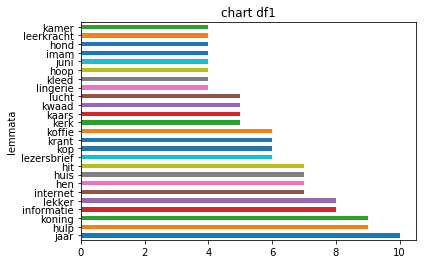

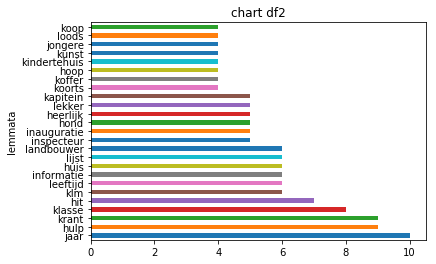

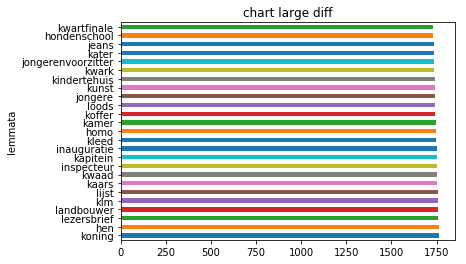

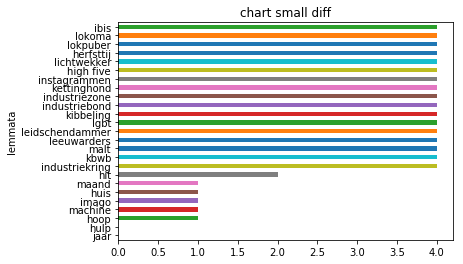

In [5]:
base_lexicon="anw"
corpus_to_search1="opensonar"
corpus_to_search2="chn"

# build frequency tables of two corpora

df_frequency_list1 = get_frequency_list(base_lexicon, "NOUN", corpus_to_search1)
display( df_frequency_list1.sort_values(ascending=False,by=['raw_freq']).head(25) )
display_df(df_frequency_list1.sort_values(ascending=True, by=['rank']).head(25), columns='raw_freq', title='chart df1', mode='chart' )

df_frequency_list2 = get_frequency_list(base_lexicon, "NOUN", corpus_to_search2)
display(df_frequency_list2.sort_values(ascending=False,by=['raw_freq']).head(25))
display_df(df_frequency_list2.sort_values(ascending=True, by=['rank']).head(25), columns='raw_freq', title='chart df2', mode='chart' )


# TODO: lemmata tonen die in 1 of 2 ontbreken

# compute the rank diff of lemmata in frequency tables

df_rankdiffs = get_rank_diff(df_frequency_list1, df_frequency_list2)

display(df_rankdiffs.sort_values(by=['rank_diff']).head(25))
display_df( df_rankdiffs.sort_values(ascending=False, by=['rank_diff']).head(25), columns='rank_diff', title='chart large diff', mode='chart' )
display_df( df_rankdiffs.sort_values(ascending=True, by=['rank_diff']).head(25), columns='rank_diff', title='chart small diff', mode='chart' )

## Case study: search in a corpus for wordforms of a lemma, which are not included of this lemma's paramadigm in a lexicon

In [13]:

base_lexicon="molex"
corpus_to_search="opensonar"

df = get_missing_wordforms(base_lexicon, "VERB", corpus_to_search)

df.to_csv( "missing_wordforms.csv", index=False)
#df = load_dataframe("missing_wordforms.csv")

display(df)


,lemma,pos,known_wordforms,unknown_wordforms
lemmata,,,,
achterliggen,achterliggen,VERB,"{achterlagen, achterlig, achterligt, achterliggen, lagen achter, liggen achter, lag achter, achtergelegen, achterliggend, achterlag, ligt achter, lig achter}",{achterliggende}
afstraffen,afstraffen,VERB,"{afstraffen, afstraf, afgestraft, afstraffend, afstrafte, afstraft, straft af, afstraften, straffen af, strafte af, straften af, straf af}",{afstraffende}
arresteren,arresteren,VERB,"{gearresteerd, arresteren, arresteer, arresteerden, arresterend, arresteert, arresteerde}",{gearresteerde}
automatiseren,automatiseren,VERB,"{geautomatiseerd, automatiseert, automatiseer, automatiserend, automatiseerde, automatiseerden, automatiseren}",{geautomatiseerde}
belangstellen,belangstellen,VERB,"{belangstellen, belangstellend, stelt belang, stellen belang, stelden belang, belangstelt, stel belang, stelde belang, belanggesteld, belangstelde, belangstel, belangstelden}",{belangstellenden}
bijkomen,bijkomen,VERB,"{komt bij, kom bij, bijkomen, bijkwamen, kwam bij, bijkomt, bijgekomen, bijkwam, kwamen bij, bijkom, bijkomend, komen bij}",{bijkomende}
bijpassen,bijpassen,VERB,"{pasten bij, pas bij, passen bij, paste bij, bijgepast, bijpas, bijpast, bijpassen, bijpaste, bijpasten, bijpassend, past bij}",{bijpassende}
boeien,boeien,VERB,"{boeit, boeiden, boeide, geboeid, boeiend, boeien, boei}",{boeiende}
buizen,buizen,VERB,"{buizen, buisden, buist, buizend, buisde, gebuisd, buis}",{gebuisde}


## Case study: Train a tagger with data from an annotated corpus, an do something cool

In [55]:
from nltk.tag.perceptron import PerceptronTagger

base_lexicon="molex"
corpus_to_search="opensonar"

# we have a given word, let's say: "loop"
some_word = "loop"

# get the paradigm of the lemma our word is a part of
query = lexicon_query(some_word, pos=None, lexicon=base_lexicon)
df_paradigm = search_lexicon(query, base_lexicon)
display(df_paradigm)

# gather some pattern including our word, out of an annotated corpus
# here: DET + ADJ + 'loop'
corpus_query = corpus_query_wordform(some_word)
df_corpus = search_corpus(corpus_query, corpus=corpus_to_search, hits_only=False)

display(df_corpus)

# Train a tagger with the corpus annotations
# The input must be like: tagger.train([ [('today','NN'),('is','VBZ'),('good','JJ'),('day','NN')], [...] ])

collocations = []
nr_of_words_per_sentence = int( df_corpus.shape[1] / 3 )  # divided by the number of information layers (lemma, pos, wordform)
print("nr_of_words_per_sentence = " + str(nr_of_words_per_sentence))

for index, row in df_corpus.iterrows():
    one_collocation =  []
    wrong = False
    for i in range(0, nr_of_words_per_sentence, 1): 
        tuple = ( row['word '+str(i)], row['pos '+str(i)] )
        one_collocation.append( tuple )
        if (row['word '+str(i)] is None or row['pos '+str(i)] is None):
            wrong = True
    if wrong is False:
        collocations.append(one_collocation)
    
print(collocations)

print(type(collocations))


print('training now...')
tagger = PerceptronTagger(load=False)
tagger.train(collocations)

# Use the trained tagger to tag unknown collocations
# The input must be like: tagger.tag(['today','is','a','beautiful','day'])

print('tagging now...')
sentence = 'Mijn buurman kijkt door de loop van zijn geweer'
tagged_sentence = tagger.tag( sentence.split() )

print(tagged_sentence)


# Know we can lemmatize each occurence of our lemma in the new sentences

,Gender,Number,hyphenation,lemEntryId,lemPos,lemma,wordform,wordformId,wordformPos
0,http://universaldependencies.org/u/feat/Gender.html#Masc,http://universaldependencies.org/u/feat/Number.html#Sing,loop,http://rdf.ivdnt.org/lexica/diamant/entry/molex/45573,http://universaldependencies.org/u/pos/NOUN,loop,loop,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/89078,http://universaldependencies.org/u/pos/NOUN
1,http://universaldependencies.org/u/feat/Gender.html#Masc,http://universaldependencies.org/u/feat/Number.html#Plur,lo/pen,http://rdf.ivdnt.org/lexica/diamant/entry/molex/45573,http://universaldependencies.org/u/pos/NOUN,loop,lopen,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/156030,http://universaldependencies.org/u/pos/NOUN
2,http://universaldependencies.org/u/feat/Gender.html#Masc,http://universaldependencies.org/u/feat/Number.html#Sing,loop,http://rdf.ivdnt.org/lexica/diamant/entry/molex/45573,http://universaldependencies.org/u/pos/NOUN,loop,loop,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/89078,http://universaldependencies.org/u/pos/NOUN
3,,http://universaldependencies.org/u/feat/Number.html#Sing,loop,http://rdf.ivdnt.org/lexica/diamant/entry/molex/106637,http://universaldependencies.org/u/pos/VERB,lopen,loop,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/560193,http://universaldependencies.org/u/pos/VERB
4,,http://universaldependencies.org/u/feat/Number.html#Sing,loop,http://rdf.ivdnt.org/lexica/diamant/entry/molex/106637,http://universaldependencies.org/u/pos/VERB,lopen,loop,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/822354,http://universaldependencies.org/u/pos/VERB


http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=opensonar&query=%5Bword%3D%22loop%22%5D
0


,lemma 0,lemma 1,lemma 2,lemma 3,lemma 4,lemma 5,lemma 6,lemma 7,lemma 8,lemma 9,...,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10
0,intuïtie,kreeft,:,advies,:,lopen,niet,te,hard,van,...,kreeft,:,advies,:,loop,niet,te,hard,van,stapel
1,bewaken,zodat,ik,geen,risico,loop,ivm,inbraak,enz,enz,...,zodat,ik,geen,risico,loop,ivm,inbraken,enz,enz,Jij
2,rennen,naar,buiten,..,ik,lopen,naar,een,paar,auto\,...,naar,buiten,..,Ik,loop,naar,een,paar,auto\'s,die
3,denken,zullen,beïnvloeden,in,de,loop,van,de,volgend,25,...,zal,beïnvloeden,in,de,loop,van,de,volgende,25,jaar
4,nou,dat,kloppen,",",ik,loop,sinds,gisteren,niet,veel,...,dat,klopt,",",ik,loop,sinds,gisteren,niet,meer,zo
5,de,mens,er,in,de,loop,van,de,eeuw,mee,...,mens,er,in,de,loop,van,de,eeuwen,mee,deed
6,weer,over,gaan,in,de,loop,van,de,tijd,.,...,over,gaat,in,de,loop,van,de,tijd,.,Mij
7,boembaloe,ik,lopen,al,dag,het,lied,van,NOUN,PRON,...,van,None,None,None,None,None,None,None,None,None
8,due,to,a,positive,feedback,loop,.,As,sea,ice,...,to,a,positive,feedback,loop,.,As,sea,ice,melts
9,aan,men,hart,liggen,",",lopen,gewoon,verlore,;,weten,...,men,hart,ligt,",",loop,gewoon,verlore,;,weet,met


nr_of_words_per_sentence = 11
[[('intuïtie', 'NOUN'), ('kreeft', 'NOUN'), (':', 'PUNCT'), ('advies', 'NOUN'), (':', 'PUNCT'), ('loop', 'VERB'), ('niet', 'ADV'), ('te', 'ADV'), ('hard', 'ADJ'), ('van', 'ADP'), ('stapel', 'NOUN')], [('bewaken', 'VERB'), ('zodat', 'SCONJ'), ('ik', 'PRON'), ('geen', 'DET'), ('risico', 'NOUN'), ('loop', 'NOUN'), ('ivm', 'NOUN'), ('inbraken', 'NOUN'), ('enz', 'SYM OR X'), ('enz', 'SYM OR X'), ('Jij', 'PRON')], [('ren', 'VERB'), ('naar', 'ADP'), ('buiten', 'ADP'), ('..', 'PUNCT'), ('Ik', 'PRON'), ('loop', 'VERB'), ('naar', 'ADP'), ('een', 'DET'), ('paar', 'NOUN'), ("auto\\'s", 'NOUN'), ('die', 'PRON')], [('denken', 'VERB'), ('zal', 'VERB'), ('beïnvloeden', 'VERB'), ('in', 'ADP'), ('de', 'DET'), ('loop', 'NOUN'), ('van', 'ADP'), ('de', 'DET'), ('volgende', 'VERB'), ('25', 'NUM'), ('jaar', 'NOUN')], [('nou', 'ADV'), ('dat', 'PRON'), ('klopt', 'VERB'), (',', 'PUNCT'), ('ik', 'PRON'), ('loop', 'NOUN'), ('sinds', 'ADP'), ('gisteren', 'ADV'), ('niet', 'ADV'), ('mee